In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go

from odf.opendocument import load as odf_load

In [19]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [20]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Standard error of autocorrelation


In [21]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`


In [22]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


### Plot of autocorrelation function

In [23]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


### Get multiple regression coefficients

In [24]:
def get_multiple_regress_coeff(df, n_vars=2, with_intercept=True):  

  regress_obj = LinearRegression(fit_intercept=with_intercept)

  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = regress_obj.fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]

    
    regress = regress_obj.fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [25]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False, with_intercept=True, is_reg_diff=False):

  """
  new_column (dict) : a dictionary mapping to rename df header
  is_reg_diff:
    True - if we perform regression difference of Y_t and X_t
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars, with_intercept=with_intercept)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]
  #print(f"b_arr: {b_arr}")
  
  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()

  if with_intercept:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))
  else:
    s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars))

  # -- compute cofactor matrix 
  if with_intercept:
    X_arr = np.ones_like(data_struct)
    X_arr[:,1:] = data_struct[:,1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  else:
    X_arr = data_struct[:, 1:]
    cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  
  if with_intercept:
    dof = num_of_samples - n_vars - 1;          # degrees of freedom
    for i in range(1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)
  else:
    dof = num_of_samples - n_vars;          # degrees of freedom
    for i in range(1, 1+n_vars):
      SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i-1, i-1])
      t_scores[i] = b_arr[i] / SE_coef[i]
      p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a survival function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  if with_intercept:
    SSR = ((hat_Y - meanY)**2).sum()
    SST = ((data_struct[:, 0] - meanY)**2).sum()
  else:
    SSR = (hat_Y**2).sum()
    SST = (data_struct[:, 0]**2).sum()

  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])

  if with_intercept:
    anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  else:
    anova_dof = np.array([n_vars, num_of_samples - n_vars, num_of_samples], dtype=int)
  
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  if with_intercept:
    print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  else:
    if str_b_predictor[1] == "+":
      str_b_predictor = str_b_predictor[3:]
    print(f"{new_column[0]} = {str_b_predictor}")
  display(table_predictor)
  if is_reg_diff:
    print(f"s_yxs = {s_yxs:.4f}")
  else:
    print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.4f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.4f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".4f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  # -- print Durbin-Watson statistics
  print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "corr_matrix": corr_matrix, 
    "R_sq": R_sq, "dw_stats": dw_stats}


### Perform Durbin-Watson Test

In [26]:
def test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl_arr):
  for significance_lvl in significance_lvl_arr:
    if abs(significance_lvl - 0.05) < 1e-4:
      d_lower = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")
      
    elif abs(significance_lvl - 0.01) < 1e-4:
      d_lower = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")

    test_status = "" 
    if dw_stats > d_upper:
      test_status = "null hypothesis accepted"
    elif dw_stats < d_lower:
      test_status = "null hypotesis rejected"
    else:
      test_status = "inconclusive"

    print(f"significance_lvl: {significance_lvl}")
    print(f"  durbin-watson statistics: {dw_stats:.2f}")
    print(f"  durbin-watson critical values (d_L, d_U): {d_lower, d_upper}")
    print(f"  conclusion: {test_status}\n")

### Durbin-Watson critical value

In [27]:
df_dw_crit_05 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_05.ods",
  header=[1, 2], index_col=0)
df_dw_crit_01 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_01.ods", 
  header=[1, 2], index_col=0)

## Load the data

### Sales and income data

In [28]:
filename = "07-table-05-sears-sales.ods"

df = read_ods(filename)

df["ln Y_t"] = np.log(df["Sales ($1,000s) Y_t"])
df["ln X_t"] = np.log(df["Income ($ millions) X_t"])

df["diff ln Y_t"] = df["ln Y_t"] - df["ln Y_t"].shift(1)
df["diff ln X_t"] = df["ln X_t"] - df["ln X_t"].shift(1)

df

,Year,"Sales ($1,000s) Y_t",Income ($ millions) X_t,ln Y_t,ln X_t,diff ln Y_t,diff ln X_t
0,1976,3307,273.4,8.103797,5.610936,NaN,NaN
1,1977,3556,291.3,8.176392,5.674354,0.072595,0.063418
2,1978,3601,306.9,8.188967,5.726522,0.012575,0.052168
3,1979,3721,317.1,8.221748,5.759217,0.032781,0.032695
4,1980,4036,336.1,8.303009,5.817409,0.081262,0.058192
5,1981,4134,349.4,8.327001,5.856217,0.023991,0.038809
6,1982,4268,362.9,8.358901,5.894127,0.031900,0.037910
7,1983,4578,383.9,8.429018,5.950382,0.070117,0.056255
8,1984,5093,402.8,8.535622,5.998440,0.106605,0.048058
9,1985,5716,437.0,8.651025,6.079933,0.115402,0.081493


## Log linear regression models

$$
\begin{align*}
  Y_t &= \gamma X_t^{\beta_1} + \epsilon_t \\
  \ln{Y_t} &= \beta_0 + \beta_1 \ln{X_t} + \epsilon_t
\end{align*}
$$

where $\beta_0 = \ln{\gamma}$ and $\beta_1$ is the income elasticity of sales

### Regression Analysis

In [29]:
df_minitab = df[["ln Y_t", "ln X_t"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab

header: ['ln Y_t', 'ln X_t']


,Y,X_1
0,8.103797,5.610936
1,8.176392,5.674354
2,8.188967,5.726522
3,8.221748,5.759217
4,8.303009,5.817409
5,8.327001,5.856217
6,8.358901,5.894127
7,8.429018,5.950382
8,8.535622,5.998440
9,8.651025,6.079933


In [30]:
column_name = ["ln(Sales)", "ln(Income)"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)


Regression Analysis: ln(Sales) versus ln(Income)
The regression equation is
ln(Sales) = 1.823 + 1.117 ln(Income)


Predictor,Coef,SE Coef,t-score,p-value
Constant,1.8232,0.1434,12.71,0.0000
ln(Income),1.1173,0.0231,48.47,0.0000


s_yxs = 0.0437   R_sq = 99.2%   R-sq(adj) = 99.2%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,4.4821,4.4821,2349.133,0.0000
Residual error,19,0.0363,0.0019,,
Total,20,4.5184,,,


Durbin-Watson Statistics = 0.50


### Fitted line plot

In [31]:
df_fit = df_minitab.copy()
out_dict

{'regress': LinearRegression(),
 'corr_matrix': array([[0.99598032]]),
 'R_sq': 0.9919768017246626,
 'dw_stats': 0.4963464899111448}

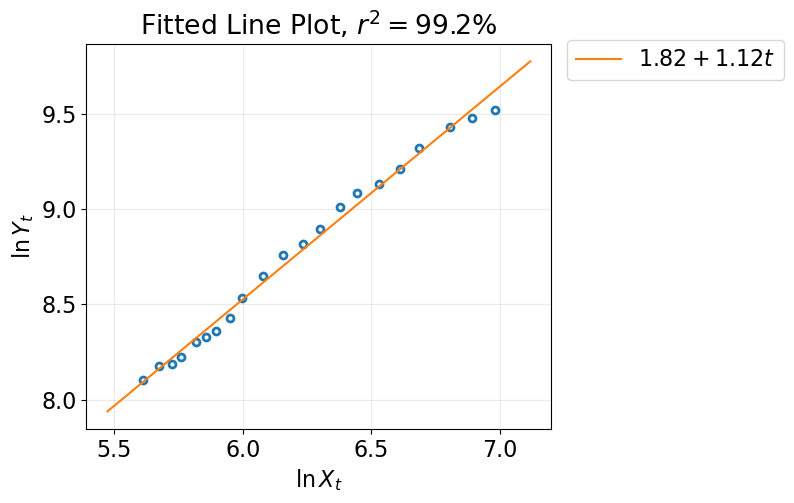

In [32]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"$\ln{X_t}$")
ax.set_ylabel(r"$\ln{Y_t}$")

rSq = out_dict["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [33]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_fit) 
k_predictors = 1
dw_stats = out_dict["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.50
  durbin-watson critical values (d_L, d_U): (1.22, 1.42)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.50
  durbin-watson critical values (d_L, d_U): (0.97, 1.16)
  conclusion: null hypotesis rejected



The Durbin-Watson statistic is small ($0.50$) and less than
$d_L = 0.97$.     
Fred concluded that the correlation between successive errors is positive and large (close to 1)

## Regression with Difference

### Regression Analysis

In [34]:
df_minitab_2 = df[["diff ln Y_t", "diff ln X_t"]]
from_column_names = df_minitab_2.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab_2 = df_minitab_2.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab_2 = df_minitab_2.dropna()
df_minitab_2 = df_minitab_2.reset_index(drop=True)

df_minitab_2


header: ['diff ln Y_t', 'diff ln X_t']


,Y,X_1
0,0.072595,0.063418
1,0.012575,0.052168
2,0.032781,0.032695
3,0.081262,0.058192
4,0.023991,0.038809
5,0.031900,0.037910
6,0.070117,0.056255
7,0.106605,0.048058
8,0.115402,0.081493
9,0.106287,0.077469


In [35]:
column_name_2 = ["Change in ln(Sales)", "Change in ln(Income)"]
out_dict_2 = get_minitab_out(df_minitab_2, n_vars=len(column_name_2)-1, 
  new_column=column_name_2, withVIF=False, withCorrMatrix=False, 
  with_intercept=False, is_reg_diff=True)


Regression Analysis: Change in ln(Sales) versus Change in ln(Income)
The regression equation is
Change in ln(Sales) = 1.010 Change in ln(Income)


Predictor,Coef,SE Coef,t-score,p-value
Constant,0.0000,0.0000,0.00,0.0000
Change in ln(Income),1.0099,0.0930,10.85,0.0000


s_yxs = 0.0297
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,0.1043,0.1043,117.827,0.0000
Residual error,19,0.0168,0.0009,,
Total,20,0.1211,,,


Durbin-Watson Statistics = 1.28


### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [36]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_minitab_2) 
k_predictors = 1
dw_stats = out_dict_2["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 1.28
  durbin-watson critical values (d_L, d_U): (1.2, 1.41)
  conclusion: inconclusive

significance_lvl: 0.01
  durbin-watson statistics: 1.28
  durbin-watson critical values (d_L, d_U): (0.95, 1.15)
  conclusion: null hypothesis accepted



Because of inclusive in the Durbin-Watson test, we use correlogram plot to check 
the residual autocorrelation

### Correlogram plot

In [37]:
df_correlogram = df_minitab_2.copy()
df_correlogram["e_t"] = df_minitab_2["Y"] - df_minitab_2["hat_Y"]
df_correlogram["t"] = np.arange(1, len(df_correlogram)+1, dtype=int)
df_correlogram

,Y,X_1,hat_Y,e_t,t
0,0.072595,0.063418,0.064045,0.008550,1
1,0.012575,0.052168,0.052684,-0.040109,2
2,0.032781,0.032695,0.033019,-0.000238,3
3,0.081262,0.058192,0.058767,0.022494,4
4,0.023991,0.038809,0.039193,-0.015201,5
5,0.031900,0.037910,0.038285,-0.006385,6
6,0.070117,0.056255,0.056811,0.013305,7
7,0.106605,0.048058,0.048534,0.058071,8
8,0.115402,0.081493,0.082299,0.033103,9
9,0.106287,0.077469,0.078236,0.028051,10


In [38]:
num_of_rk = 5 

df_acorr_analysis = get_correlogram(df_correlogram, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.274432,1.227299,1.744093,-0.468014,0.468014
1,2,-0.257852,-1.075024,3.369345,-0.502026,0.502026
2,3,-0.065264,-0.257615,3.479586,-0.530242,0.530242
3,4,0.349965,1.376854,6.847656,-0.531999,0.531999
4,5,0.160779,0.579959,7.605920,-0.580238,0.580238


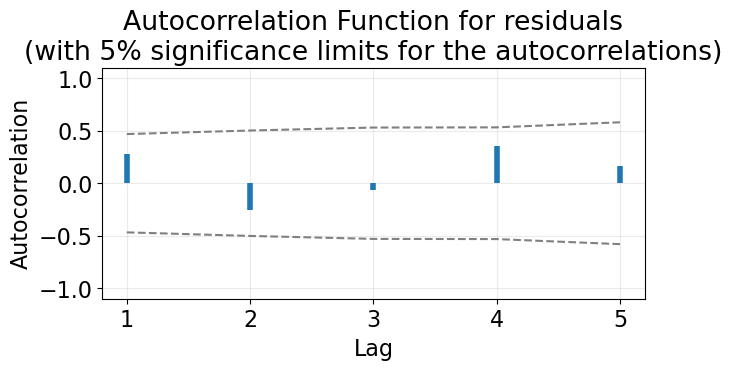

In [39]:
plot_autocorr_func(df_acorr_analysis, title=r"residuals")


The correlogram plot above shows that the autocorrelation of the residuals are well within their two standard error limits (the dashed lines in the figure)

### Forecasting from regression with differences

$$
  \begin{align*}
    \hat{Y}'_t 
      &= b_1 X'_t \\
    \ln{\hat{Y}_t} - \ln{\hat{Y}_{t-1}}
      &= b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \\
    \ln{\hat{Y}_t}
      &= \ln{\hat{Y}_{t-1}} + b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \\
    \hat{Y}_t
      &= \exp\left\{ \ln{\hat{Y}_{t-1}} + b_1 \left(\ln{X_t} - \ln{X}_{t-1}\right) \right\}
  \end{align*}
$$

In [40]:
X_t = df["Income ($ millions) X_t"]
Y_t = df["Sales ($1,000s) Y_t"]
t_forecast = 22
hat_Y_tM1_forecast = Y_t.iloc[(t_forecast-1) - 1]
X_tM1_forecast = X_t.iloc[(t_forecast - 1) - 1]
X_t_forecast = 1_185   # not from the table 
                       # estimation for disposal personal income

b1_estimate = out_dict_2["regress"].coef_[0]
# print(b1_estimate)
hat_Y_t_forecast = np.exp(
  np.log(hat_Y_tM1_forecast) + b1_estimate * (
    np.log(X_t_forecast) - np.log(X_tM1_forecast)))

print(f"Fred's forecast of Sears 1997 sales for the western region ", end="")
print(f"${hat_Y_t_forecast:,.0f} thousands")

Fred's forecast of Sears 1997 sales for the western region $15,026 thousands


In [41]:
df_forecast = pd.DataFrame()
df_forecast["t"] = np.arange(len(df))
df_forecast["Y_t"] = df["Sales ($1,000s) Y_t"]
df_forecast["X_t"] = df["Income ($ millions) X_t"]

df_forecast["Y_tM1"] = df_forecast["Y_t"].shift(1)
df_forecast["X_tM1"] = df_forecast["X_t"].shift(1)
df_forecast["hat{Y}"] = np.exp(
  np.log(df_forecast["Y_tM1"]) + b1_estimate*(
    np.log(df_forecast["X_t"]) - np.log(df_forecast["X_tM1"])))
df_forecast

,t,Y_t,X_t,Y_tM1,X_tM1,hat{Y}
0,0,3307,273.4,NaN,NaN,NaN
1,1,3556,291.3,3307.0,273.4,3525.727090
2,2,3601,306.9,3556.0,291.3,3748.369000
3,3,3721,317.1,3601.0,306.9,3721.885216
4,4,4036,336.1,3721.0,317.1,3946.226470
5,5,4134,349.4,4036.0,336.1,4197.322285
6,6,4268,362.9,4134.0,349.4,4295.339038
7,7,4578,383.9,4268.0,362.9,4517.491008
8,8,5093,402.8,4578.0,383.9,4805.666809
9,9,5716,437.0,5093.0,402.8,5529.881807


### Plot of forecasting point

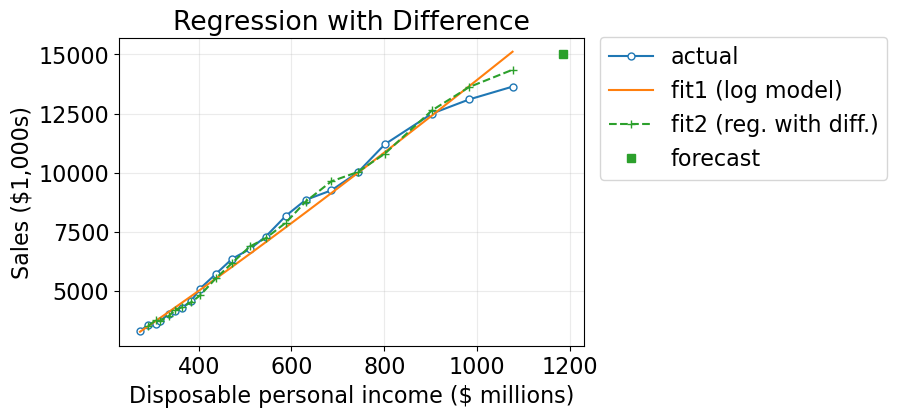

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(df_forecast["X_t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

X_t = df_forecast["X_t"]
regress1 = out_dict["regress"]
b0 = regress1.intercept_
b1 = regress1.coef_
Y_t_log_model = np.exp(b0) * (X_t**b1)
ax.plot(X_t, Y_t_log_model, linestyle="-",
  label="fit1 (log model)")

forecast_key = "hat{Y}"
fit2_plot = ax.plot(X_t, df_forecast[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label="fit2 (reg. with diff.)")

color = fit2_plot[0]._color
ax.plot([X_t_forecast], [hat_Y_t_forecast], marker='s', markersize=6, 
  linestyle="None", label="forecast", color=color)

ax.set_xlabel("Disposable personal income ($ millions)")
ax.set_ylabel("Sales ($1,000s)")
ax.set_title("Regression with Difference")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)